In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Reading Data

The following cell reads the data and places it in a dictionary formatted to:
```
{
    sub_id: {
        run_id: {
            "eeg": [],
            "aux": [],
            "label": []
        }
    }
}
```

In [2]:
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1) 

In [3]:
# data loading
eeg_dir = "data/misc/"
label_dir = "data/label/"

data = {}

# reading data
for sub_id in os.listdir(eeg_dir):
    data[sub_id] = {}

    dir_path = os.path.join(eeg_dir, sub_id) 
    for run_id in os.listdir(dir_path):

        # ignoring corrupt data
        if run_id == "run_34":
            continue

        if sub_id == "sub_1":
            if run_id in ["run_1", "run_3"]:
                continue

        if sub_id == "sub_2":
            if run_id in ["run_2"]:
                continue

        if sub_id == "sub_3":
            if run_id in ["run_2", "run_5"]:
                continue


        # getting run number
        i = int(run_id.replace("run_", ""))

        # getting path for aux and eeg
        base_path = os.path.join(dir_path, run_id)
        eeg_path = os.path.join(base_path, f"eeg_run-{i}.npy")
        aux_path = os.path.join(base_path, f"aux_run-{i}.npy")

        # getting path for label
        base_path_label = os.path.join(label_dir, sub_id)
        base_path_label = os.path.join(base_path_label, run_id)

        
        label_path = os.path.join(base_path_label, "labels.npy")

        filtered_eeg = bandpass_filter(np.load(eeg_path))
        
        data[sub_id][run_id] = {
            "eeg": np.load(eeg_path),
            "filtered_eeg": filtered_eeg,
            "aux": np.load(aux_path),
            "label": np.load(label_path)
        }        

## Data Visualization

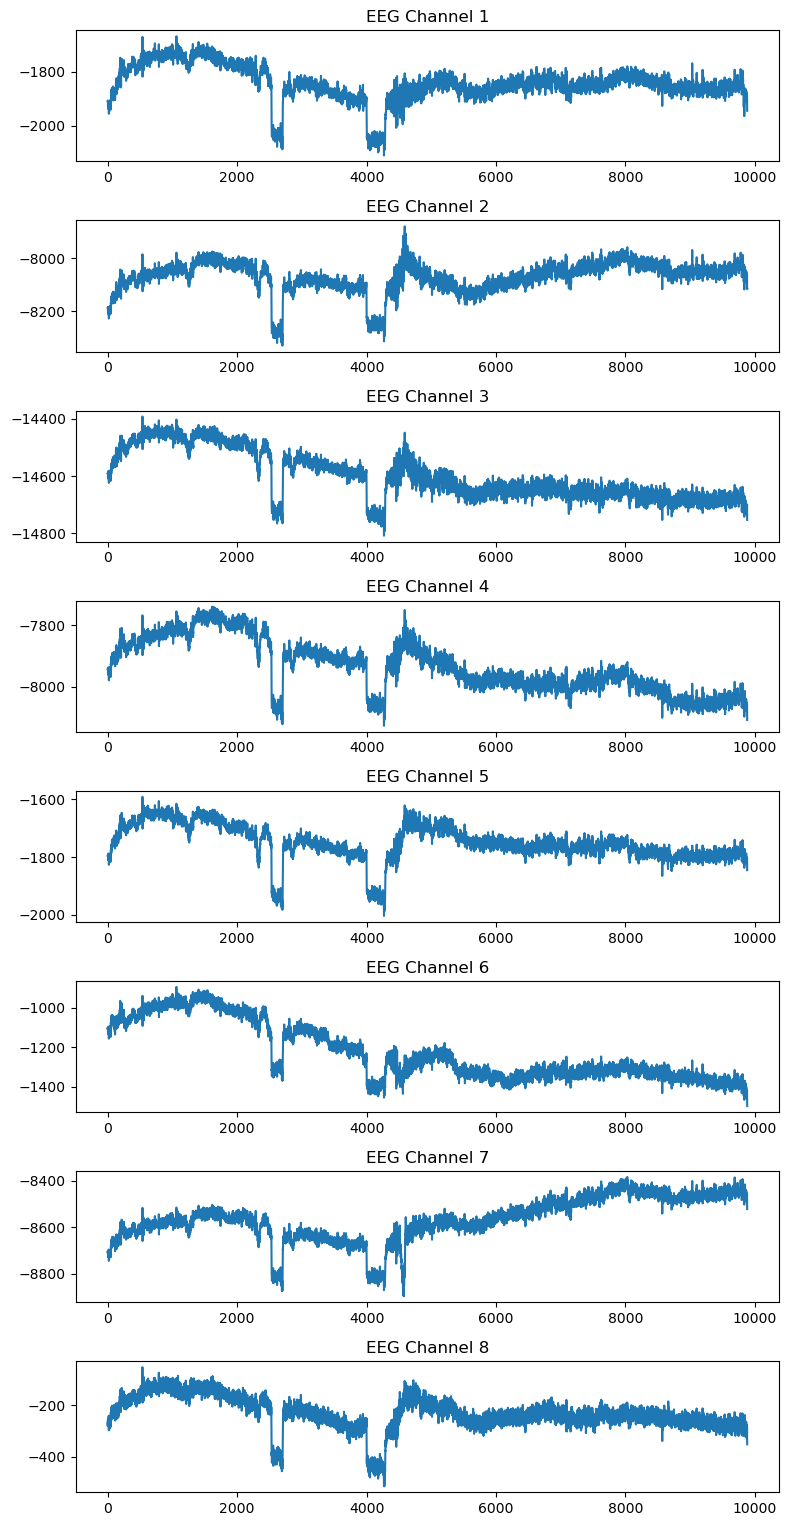

In [4]:
sub_id = "sub_5"
run_id = "run_2"
ignore = 100

eeg_data = data[sub_id][run_id]["eeg"]

# Create subplots
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

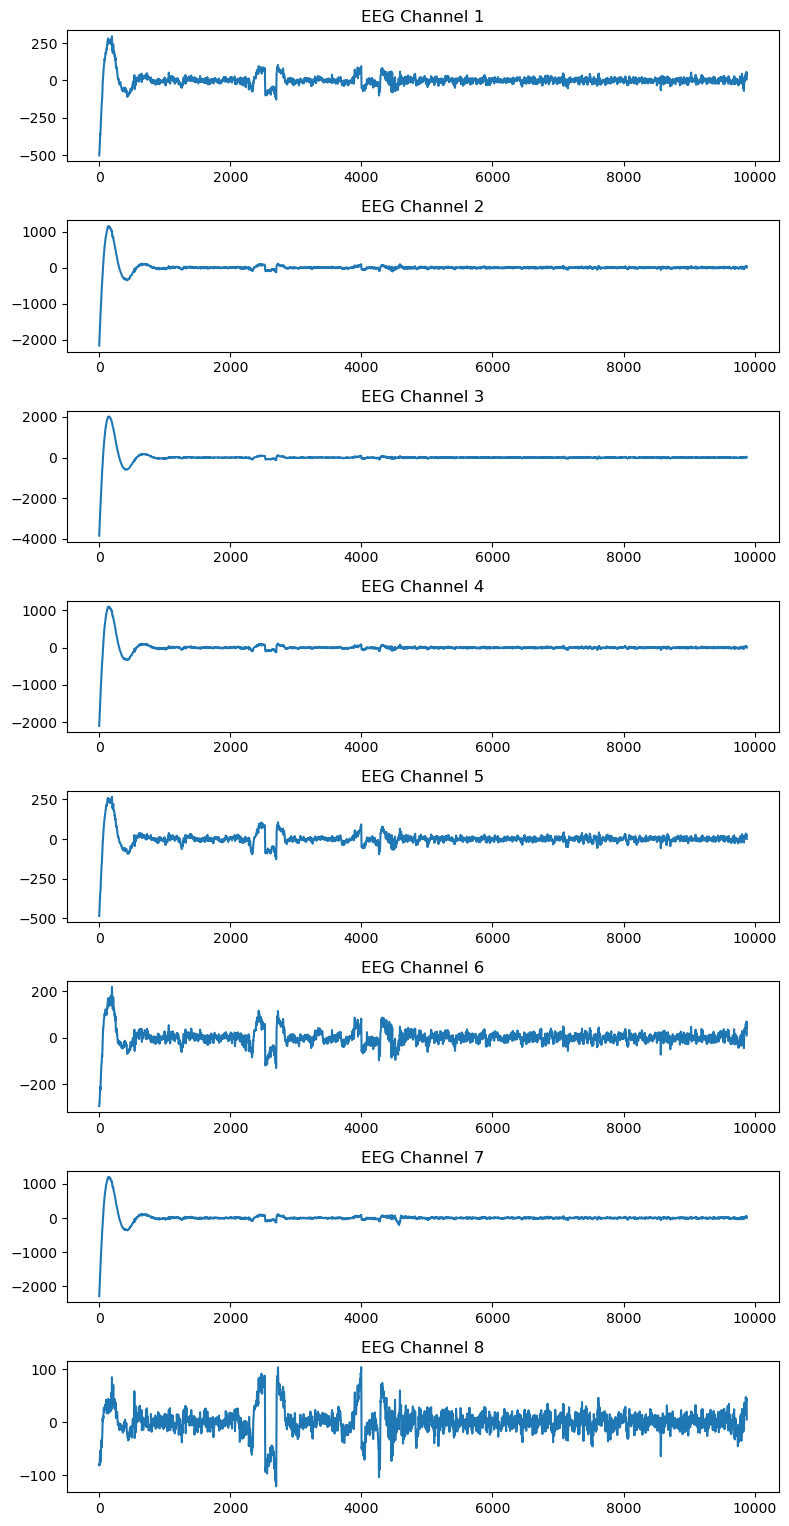

In [5]:
eeg_data = data[sub_id][run_id]["filtered_eeg"]

# Create subplots
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

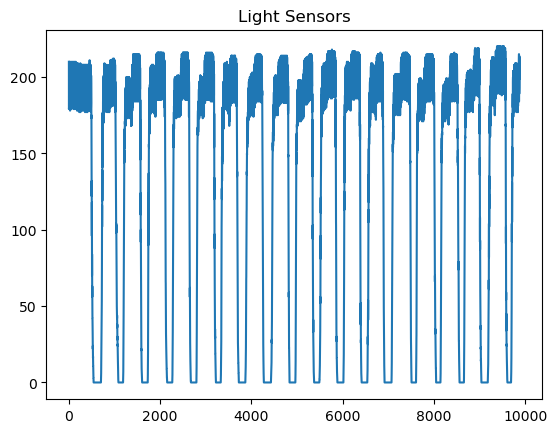

In [6]:
ignore = 100

aux_data = data[sub_id][run_id]["aux"][1]

plt.plot(np.arange(len(aux_data[ignore:])), aux_data[ignore:])
plt.title(f"Light Sensors")
plt.show()

## Cleaning the data

In [7]:
ignore = 100
pre_onset_window = 200
sample_window = 300 + pre_onset_window
cleaned_data = {}

for sub_id in list(data.keys()):
    eeg_window = []
    labels = []
    
    for run_id in list(data[sub_id].keys()):
        aux_data = data[sub_id][run_id]["aux"][1][ignore:]
        eeg_data = data[sub_id][run_id]["filtered_eeg"][:, ignore:]
        label_data = data[sub_id][run_id]["label"]
    
        labels.append(label_data)
    
        window_mask = aux_data > 10
        prev = False
        window = []
        for i, mask in enumerate(window_mask):
            if mask:
                if len(window) == 0:
                    for j in range(i-pre_onset_window, i):
                        window.append(eeg_data[:, j])
                
                window.append(eeg_data[:, i])
        
            if prev and not mask and len(window) > (100 + pre_onset_window):
                eeg_window.append(np.asarray(window))
                window = []
                
            prev = mask

    labels = np.asarray(labels).flatten()

    # asserting if data is valid
    print(len(eeg_window), len(labels))
    assert len(eeg_window) == len(labels)

    # First, split into train (70%) and temp (30%)
    eeg_train, eeg_temp, label_train, label_temp = train_test_split(
        eeg_window, labels, test_size=0.4, stratify=labels, random_state=3
    )
    
    # Split temp into validation (50%) and test (50%) ensuring stratification
    eeg_val, eeg_test, label_val, label_test = train_test_split(
        eeg_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=3
    )
    
    # Store in dictionary
    cleaned_data[sub_id] = {
        "train": {"eeg": eeg_train, "label": label_train},
        "val": {"eeg": eeg_val, "label": label_val},
        "test": {"eeg": eeg_test, "label": label_test}
    }

54 54
90 90
90 90
72 72
54 54


## Dataloader

In [8]:
class Dataset(Dataset):
    def __init__(self, data: dict, mode: str, sample_window=150):
        """
        Args:
            data: (dict) cleaned data with {eeg: [c, t], label: [t]} where
                        c is channels, and t is time
            mode: (str) one of ["hand", "rps", "both"]
        """
        if mode not in ["hand", "rps", "both"]:
            raise Exception("Not a valid mode, choose one of ['hand', 'rps', 'both']")

        self.mode = mode
        self.eeg_data = data["eeg"]
        self.sample_window = sample_window
        
        if self.mode == "hand":
            self.num_classes = 2
            self.labels = []

            for l in data["label"]:
                if "right" in l:
                    self.labels.append(0)

                elif "left" in l:
                    self.labels.append(1)

                else:
                    raise Exception("incorrect label")

        elif self.mode == "rps":
            self.num_classes = 3
            self.labels = []

            for l in data["label"]:
                if "rock" in l:
                    self.labels.append(0)

                elif "paper" in l:
                    self.labels.append(1)

                elif "scissor" in l:
                    self.labels.append(2)

                else:
                    raise Exception("incorrect label")

        else:
            self.num_classes = 6
            self.labels = []
            
            mapping = {
                "left_rock": 0, 
                "left_paper": 1, 
                "left_scissors": 2, 
                "right_rock": 3, 
                "right_paper": 4, 
                "right_scissors": 5
            }
            
            for l in data["label"]:
                if l not in list(mapping.keys()):
                    raise Exception("incorrect label")

                self.labels.append(mapping[l])


    def __len__(self):
        return len(eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx].transpose()[:, :self.sample_window]
        label = self.labels[idx]

        
        target = np.zeros([self.num_classes])
        target[label] = 1
        return torch.tensor(eeg).to(torch.float32), torch.tensor(target).to(torch.float32)

## Modelling Task 1: Left vs Right

In [9]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=2, channels=8):
        super(EEGNet, self).__init__()
        # Depthwise Convolution
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=(0, 32))
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (channels, 1), groups=16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.25)

        # Separable Convolution
        self.conv3 = nn.Conv2d(32, 32, (1, 16), padding=(0, 8))
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)


        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension [B, 1, C, T]
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.elu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pool1(x)
        x = self.dropout1(x)


        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pool2(x)
        x = self.dropout2(x)


        x = self.flatten(x)
        x = self.fc1(x)

        return F.log_softmax(x, dim=1)

def plot_cm(cm, sub_id):
     # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {sub_id}")
    plt.show()
    

In [10]:
batch_size = 4
epochs = 1000
num_classes = 2

mode = "hand"
results = {}
sub_ids = ["sub_1", "sub_2", "sub_3", "sub_4", "sub_5"]

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    # model = EEGClassifier(num_classes=num_classes, seq_length=sample_window)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0144, Val Loss: 1.1650
Epoch 200/1000, Loss: 0.0166, Val Loss: 1.2965
Epoch 300/1000, Loss: 0.0127, Val Loss: 1.2173
Epoch 400/1000, Loss: 0.0169, Val Loss: 1.2946
Epoch 500/1000, Loss: 0.0155, Val Loss: 1.2196
Epoch 600/1000, Loss: 0.0181, Val Loss: 1.2149
Epoch 700/1000, Loss: 0.0154, Val Loss: 1.1653
Epoch 800/1000, Loss: 0.0130, Val Loss: 1.1175
Epoch 900/1000, Loss: 0.0112, Val Loss: 1.1955
Epoch 1000/1000, Loss: 0.0162, Val Loss: 1.0643
============== sub_2 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0749, Val Loss: 0.9070
Epoch 200/1000, Loss: 0.0852, Val Loss: 0.8137
Epoch 300/1000, Loss: 0.0598, Val Loss: 1.0449
Epoch 400/1000, Loss: 0.0666, Val Loss: 1.0259
Epoch 500/1000, Loss: 0.1308, Val Loss: 1.1117
Epoch 600/1000, Loss: 0.0950, Val Loss: 0.9056
Epoch 700/1000, Loss: 0.0744, Val Loss: 1.1607
Epoch 800/1000, Loss: 0.0409, Val Loss: 1.0574
Epoch 900/1000, Loss: 0.0693, Val Loss: 1.0864
Epoch 1000/1000, Loss: 0.0815, Val Loss: 0.9154
============== sub_3 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0554, Val Loss: 1.0413
Epoch 200/1000, Loss: 0.0762, Val Loss: 0.9843
Epoch 300/1000, Loss: 0.0798, Val Loss: 0.8860
Epoch 400/1000, Loss: 0.0934, Val Loss: 0.8495
Epoch 500/1000, Loss: 0.0896, Val Loss: 0.8298
Epoch 600/1000, Loss: 0.0893, Val Loss: 0.7755
Epoch 700/1000, Loss: 0.1028, Val Loss: 0.8320
Epoch 800/1000, Loss: 0.0956, Val Loss: 0.8808
Epoch 900/1000, Loss: 0.1043, Val Loss: 0.8506
Epoch 1000/1000, Loss: 0.0760, Val Loss: 0.8997
============== sub_4 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0152, Val Loss: 0.5540
Epoch 200/1000, Loss: 0.0171, Val Loss: 0.6322
Epoch 300/1000, Loss: 0.0172, Val Loss: 0.6957
Epoch 400/1000, Loss: 0.0147, Val Loss: 0.7396
Epoch 500/1000, Loss: 0.0136, Val Loss: 0.6504
Epoch 600/1000, Loss: 0.0125, Val Loss: 0.5283
Epoch 700/1000, Loss: 0.0138, Val Loss: 0.6149
Epoch 800/1000, Loss: 0.0215, Val Loss: 0.7015
Epoch 900/1000, Loss: 0.0138, Val Loss: 0.7218
Epoch 1000/1000, Loss: 0.0161, Val Loss: 0.7682
============== sub_5 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0676, Val Loss: 1.0124
Epoch 200/1000, Loss: 0.0914, Val Loss: 0.9198
Epoch 300/1000, Loss: 0.0968, Val Loss: 1.0732
Epoch 400/1000, Loss: 0.0825, Val Loss: 0.9922
Epoch 500/1000, Loss: 0.0878, Val Loss: 0.8452
Epoch 600/1000, Loss: 0.0999, Val Loss: 0.8964
Epoch 700/1000, Loss: 0.0626, Val Loss: 0.8543
Epoch 800/1000, Loss: 0.0580, Val Loss: 0.9381
Epoch 900/1000, Loss: 0.1059, Val Loss: 0.9047
Epoch 1000/1000, Loss: 0.0779, Val Loss: 0.9586


Baseline (Random guess): 0.5
sub_1 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


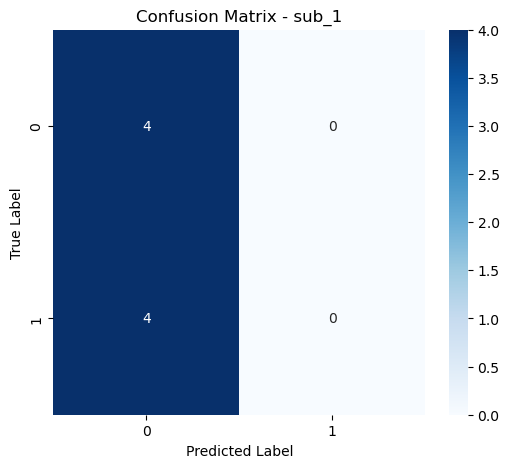

sub_2 ==> Precision: 0.5, Recall: 1.0, F1-score: 0.6666666666666666


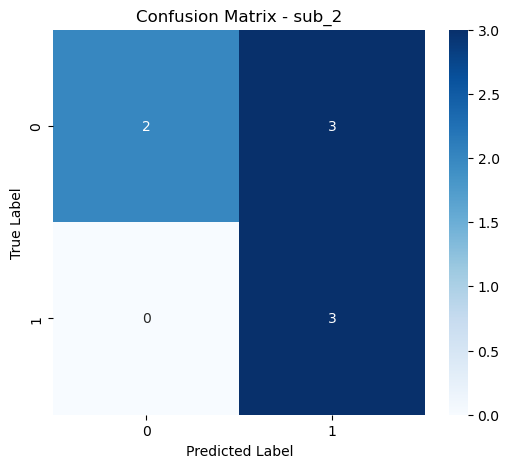

sub_3 ==> Precision: 0.5, Recall: 0.5, F1-score: 0.5


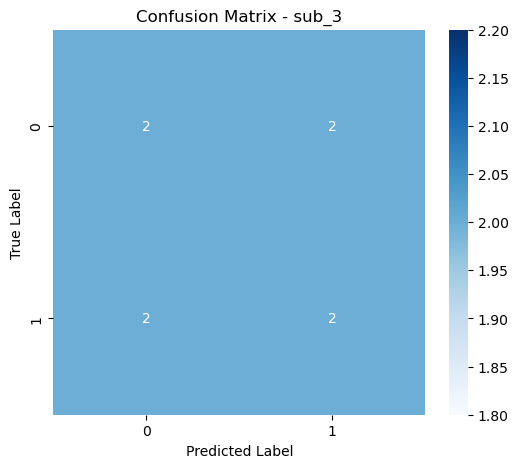

sub_4 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


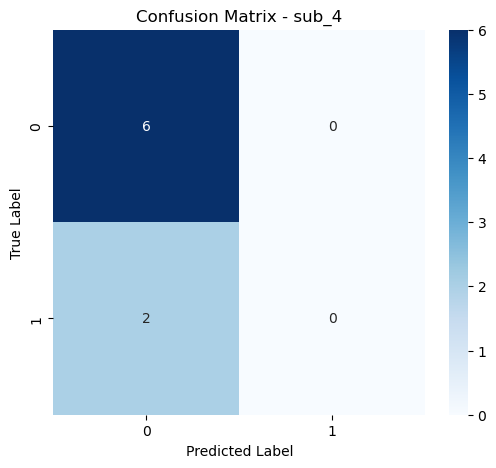

In [11]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 2: Rock vs Paper vs Scisors

In [12]:
batch_size = 1
num_classes = 3

mode = "rps"
results = {}

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    # model = EEGClassifier(num_classes=num_classes, seq_length=sample_window)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0084, Val Loss: 1.5575
Epoch 200/1000, Loss: 0.0088, Val Loss: 1.4811
Epoch 300/1000, Loss: 0.0079, Val Loss: 1.5992
Epoch 400/1000, Loss: 0.0082, Val Loss: 1.4746
Epoch 500/1000, Loss: 0.0086, Val Loss: 1.5286
Epoch 600/1000, Loss: 0.0072, Val Loss: 1.5499
Epoch 700/1000, Loss: 0.0062, Val Loss: 1.6534
Epoch 800/1000, Loss: 0.0085, Val Loss: 1.5280
Epoch 900/1000, Loss: 0.0063, Val Loss: 1.4983
Epoch 1000/1000, Loss: 0.0091, Val Loss: 1.6715
============== sub_2 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0939, Val Loss: 2.1609
Epoch 200/1000, Loss: 0.0896, Val Loss: 2.2404
Epoch 300/1000, Loss: 0.1218, Val Loss: 2.2603
Epoch 400/1000, Loss: 0.1131, Val Loss: 2.4788
Epoch 500/1000, Loss: 0.1382, Val Loss: 2.3025
Epoch 600/1000, Loss: 0.1169, Val Loss: 2.3058
Epoch 700/1000, Loss: 0.1163, Val Loss: 2.2647
Epoch 800/1000, Loss: 0.1278, Val Loss: 2.2344
Epoch 900/1000, Loss: 0.1304, Val Loss: 2.3212
Epoch 1000/1000, Loss: 0.1214, Val Loss: 2.3470
============== sub_3 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.1724, Val Loss: 1.9094
Epoch 200/1000, Loss: 0.2110, Val Loss: 1.8927
Epoch 300/1000, Loss: 0.2008, Val Loss: 1.8028
Epoch 400/1000, Loss: 0.2102, Val Loss: 1.8711
Epoch 500/1000, Loss: 0.2010, Val Loss: 1.7671
Epoch 600/1000, Loss: 0.1639, Val Loss: 1.7414
Epoch 700/1000, Loss: 0.2182, Val Loss: 1.9889
Epoch 800/1000, Loss: 0.2413, Val Loss: 1.8290
Epoch 900/1000, Loss: 0.2143, Val Loss: 1.8049
Epoch 1000/1000, Loss: 0.1732, Val Loss: 1.8028
============== sub_4 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0103, Val Loss: 2.4249
Epoch 200/1000, Loss: 0.0111, Val Loss: 2.4758
Epoch 300/1000, Loss: 0.0101, Val Loss: 2.4788
Epoch 400/1000, Loss: 0.0108, Val Loss: 2.4763
Epoch 500/1000, Loss: 0.0136, Val Loss: 2.3257
Epoch 600/1000, Loss: 0.0126, Val Loss: 2.0322
Epoch 700/1000, Loss: 0.0112, Val Loss: 2.2578
Epoch 800/1000, Loss: 0.0133, Val Loss: 2.3664
Epoch 900/1000, Loss: 0.0106, Val Loss: 2.4427
Epoch 1000/1000, Loss: 0.0139, Val Loss: 2.1740
============== sub_5 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0064, Val Loss: 1.5985
Epoch 200/1000, Loss: 0.0070, Val Loss: 1.4192
Epoch 300/1000, Loss: 0.0062, Val Loss: 1.5456
Epoch 400/1000, Loss: 0.0067, Val Loss: 1.3629
Epoch 500/1000, Loss: 0.0058, Val Loss: 1.4585
Epoch 600/1000, Loss: 0.0068, Val Loss: 1.5067
Epoch 700/1000, Loss: 0.0072, Val Loss: 1.4541
Epoch 800/1000, Loss: 0.0070, Val Loss: 1.4312
Epoch 900/1000, Loss: 0.0053, Val Loss: 1.3041
Epoch 1000/1000, Loss: 0.0053, Val Loss: 1.4971


Baseline (Random guess): 0.3333333333333333
sub_1 ==> Precision: 0.7777777777777778, Recall: 0.5555555555555555, F1-score: 0.5


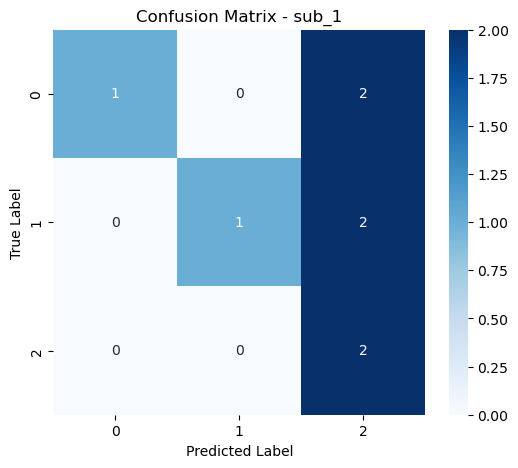

sub_2 ==> Precision: 0.2333333333333333, Recall: 0.27777777777777773, F1-score: 0.22142857142857145


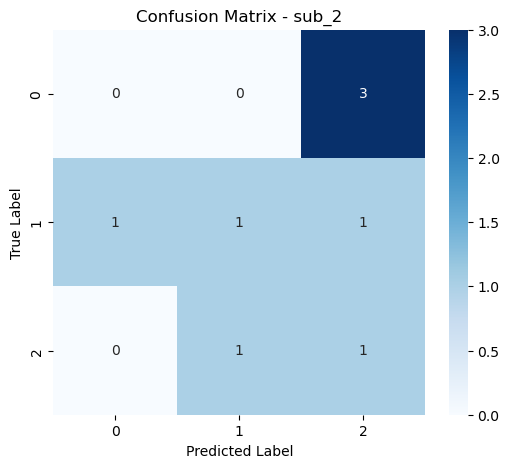

sub_3 ==> Precision: 0.16666666666666666, Recall: 0.16666666666666666, F1-score: 0.125


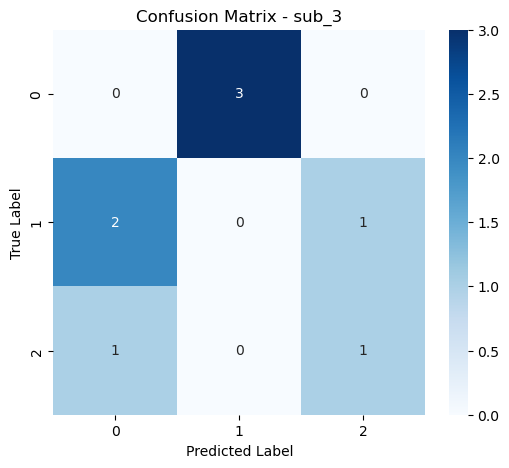

sub_4 ==> Precision: 0.08333333333333333, Recall: 0.16666666666666666, F1-score: 0.08333333333333333


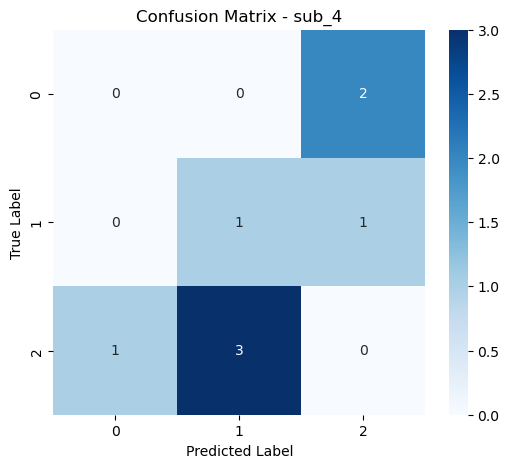

In [13]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 3: Rock vs Paper vs Scisors

In [14]:
batch_size = 1
num_classes = 6

mode = "both"
results = {}

for sub_id in sub_ids:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    # model = EEGClassifier(num_classes=num_classes, seq_length=sample_window)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0178, Val Loss: 2.5123
Epoch 200/1000, Loss: 0.0157, Val Loss: 2.5576
Epoch 300/1000, Loss: 0.0134, Val Loss: 2.5158
Epoch 400/1000, Loss: 0.0202, Val Loss: 2.5090
Epoch 500/1000, Loss: 0.0144, Val Loss: 2.5390
Epoch 600/1000, Loss: 0.0141, Val Loss: 2.3104
Epoch 700/1000, Loss: 0.0155, Val Loss: 2.3750
Epoch 800/1000, Loss: 0.0145, Val Loss: 2.2621
Epoch 900/1000, Loss: 0.0105, Val Loss: 2.4662
Epoch 1000/1000, Loss: 0.0114, Val Loss: 2.3382
============== sub_2 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.1193, Val Loss: 2.9747
Epoch 200/1000, Loss: 0.1264, Val Loss: 2.9942
Epoch 300/1000, Loss: 0.1110, Val Loss: 2.6706
Epoch 400/1000, Loss: 0.1142, Val Loss: 2.7877
Epoch 500/1000, Loss: 0.1099, Val Loss: 2.9694
Epoch 600/1000, Loss: 0.1282, Val Loss: 2.9819
Epoch 700/1000, Loss: 0.1287, Val Loss: 2.8994
Epoch 800/1000, Loss: 0.1123, Val Loss: 2.7607
Epoch 900/1000, Loss: 0.1040, Val Loss: 3.0174
Epoch 1000/1000, Loss: 0.1020, Val Loss: 2.6707
============== sub_3 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.1290, Val Loss: 2.5755
Epoch 200/1000, Loss: 0.2227, Val Loss: 2.8035
Epoch 300/1000, Loss: 0.1888, Val Loss: 2.4036
Epoch 400/1000, Loss: 0.2026, Val Loss: 2.6853
Epoch 500/1000, Loss: 0.1851, Val Loss: 2.4409
Epoch 600/1000, Loss: 0.1851, Val Loss: 2.2926
Epoch 700/1000, Loss: 0.1699, Val Loss: 2.7778
Epoch 800/1000, Loss: 0.2036, Val Loss: 2.4563
Epoch 900/1000, Loss: 0.1663, Val Loss: 2.3766
Epoch 1000/1000, Loss: 0.2085, Val Loss: 2.4445
============== sub_4 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0258, Val Loss: 2.6266
Epoch 200/1000, Loss: 0.0209, Val Loss: 2.7233
Epoch 300/1000, Loss: 0.0228, Val Loss: 2.6912
Epoch 400/1000, Loss: 0.0243, Val Loss: 2.7652
Epoch 500/1000, Loss: 0.0261, Val Loss: 2.8478
Epoch 600/1000, Loss: 0.0227, Val Loss: 2.6586
Epoch 700/1000, Loss: 0.0197, Val Loss: 2.7232
Epoch 800/1000, Loss: 0.0259, Val Loss: 2.8838
Epoch 900/1000, Loss: 0.0218, Val Loss: 2.9040
Epoch 1000/1000, Loss: 0.0216, Val Loss: 2.6644
============== sub_5 ==============

sample_window = 500


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0159, Val Loss: 2.4744
Epoch 200/1000, Loss: 0.0154, Val Loss: 2.7196
Epoch 300/1000, Loss: 0.0166, Val Loss: 2.5667
Epoch 400/1000, Loss: 0.0126, Val Loss: 2.4569
Epoch 500/1000, Loss: 0.0132, Val Loss: 2.4062
Epoch 600/1000, Loss: 0.0130, Val Loss: 2.4986
Epoch 700/1000, Loss: 0.0111, Val Loss: 2.4327
Epoch 800/1000, Loss: 0.0137, Val Loss: 2.3546
Epoch 900/1000, Loss: 0.0172, Val Loss: 2.4978
Epoch 1000/1000, Loss: 0.0134, Val Loss: 2.5484


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline (Random guess): 0.16666666666666666
sub_1 ==> Precision: 0.08, Recall: 0.2, F1-score: 0.14285714285714285


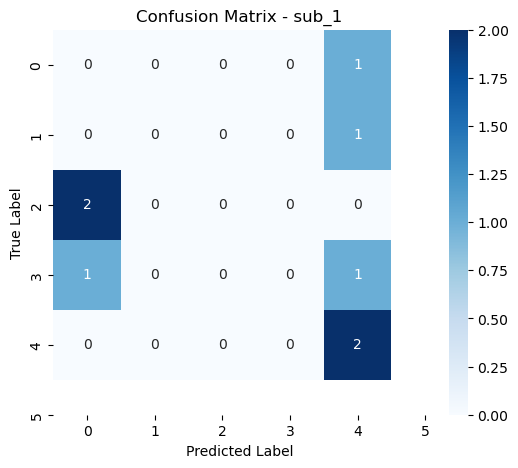

sub_2 ==> Precision: 0.125, Recall: 0.3333333333333333, F1-score: 0.13333333333333333


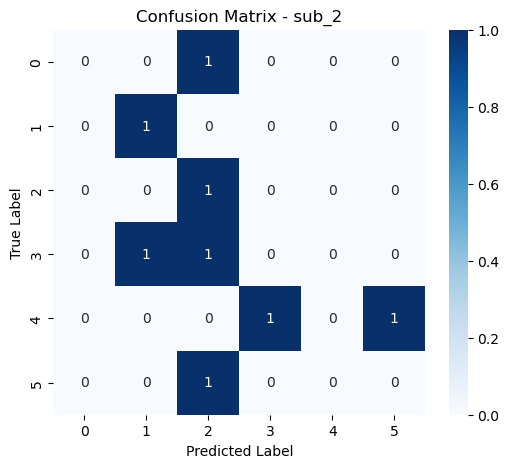

sub_3 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


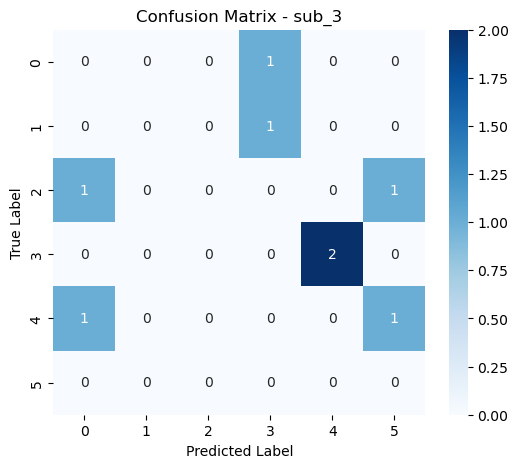

sub_4 ==> Precision: 0.05555555555555555, Recall: 0.08333333333333333, F1-score: 0.1


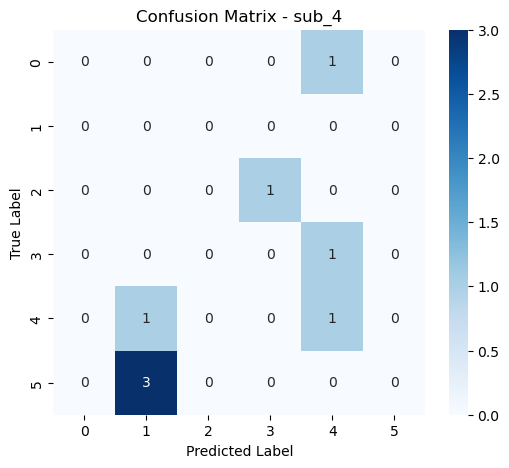

In [15]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)